# Генерация датасета


In [1]:
import os
import random as rnd
import cv2
import numpy as np
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# TODO Move into config.yaml
LOGO_URLS = ['/content/drive/MyDrive/logo_dataset/logos/'+el for el in os.listdir('/content/drive/MyDrive/logo_dataset/logos')]
BG_URLS = ['/content/drive/MyDrive/logo_dataset/backgrounds/'+el for el in os.listdir('/content/drive/MyDrive/logo_dataset/backgrounds')]

In [4]:
os.mkdir('/content/dataset')
os.mkdir('/content/dataset/train')
os.mkdir('/content/dataset/val')
os.mkdir('/content/dataset/test')

In [5]:
class DataHolder:
    def __init__(self):
        self.logos = list()
        self.source_bgs = list()
        self.bgs = list()
        self.target_size = (600, 600)

    def clean_train() -> None:
      for el in os.listdir('/content/dataset/train'):
        os.remove('/content/dataset/train/'+el)

    def clean_val() -> None:
      for el in os.listdir('/content/dataset/val'):
        os.remove('/content/dataset/val/'+el)

    @staticmethod
    def resize_logo(logo: np.array, width = None, height = None, inter = cv2.INTER_AREA) -> np.array:
      dim = None
      (h, w) = logo.shape[:2]
      if width is None and height is None:
          return logo

      if width is None:
          r = height / float(h)
          dim = (int(w * r), height)
      else:
          r = width / float(w)
          dim = (width, int(h * r))

      resized = cv2.resize(logo, dim, interpolation = inter)
      return resized


    def prepare_data(self) -> None:
      for logo in LOGO_URLS:
        lg = cv2.imread(logo, cv2.IMREAD_UNCHANGED)
        self.logos.append(self.resize_logo(lg, 150))
      for bg in BG_URLS:
        back = cv2.imread(bg, cv2.IMREAD_UNCHANGED)
        back = cv2.cvtColor(back, cv2.COLOR_RGB2RGBA)
        self.source_bgs.append(back)
      for bg in self.source_bgs:
        self.generate_bg(bg)


    def generate_bg(self, source_bg: np.array) -> None:
      bgs = rnd.sample(self.source_bgs, 3)
      source_bg = cv2.resize(source_bg, self.target_size)
      for bg in bgs:
        scale = rnd.uniform(1.0, 2.5)
        scaled_background = cv2.resize(bg, (int(self.target_size[0] * scale), int(self.target_size[1] * scale)))
        angle = rnd.uniform(-60, 60)
        M = cv2.getRotationMatrix2D((self.target_size[0] / 2, self.target_size[1] / 2), angle, 1)
        rotated_background = cv2.warpAffine(scaled_background, M, self.target_size)
        x_offset = rnd.randint(0, self.target_size[0] - rotated_background.shape[1])
        y_offset = rnd.randint(0, self.target_size[1] - rotated_background.shape[0])
        mask = cv2.threshold(rotated_background, 0, 255, cv2.THRESH_BINARY)[1]
        alpha = rnd.uniform(0.3, 0.6)
        rotated_background_with_alpha = cv2.addWeighted(rotated_background, alpha, source_bg, 1 - alpha, 0)
        source_bg[y_offset:y_offset+self.target_size[1], x_offset:x_offset+self.target_size[0]] = \
            source_bg[y_offset:y_offset+self.target_size[1], x_offset:x_offset+self.target_size[0]] * (1 - mask / 255) + \
            rotated_background_with_alpha * (mask / 255)
      self.bgs.append(source_bg)

In [6]:
holder = DataHolder()
holder.prepare_data()

In [7]:
DataHolder.clean_train()
DataHolder.clean_val()

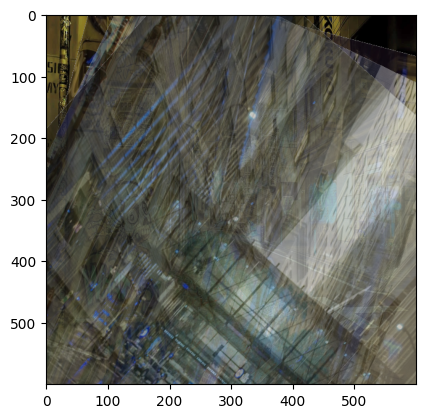

In [8]:
plt.imshow(holder.bgs[2])

In [9]:
SAMPLE_INDEX = 0

class ImageGenerator:
    def __init__(self, logo: np.array, cls: int, logos_per_bg_count=2):
        self.logo = logo
        self.cls = cls
        self.logos_per_bg_count = logos_per_bg_count
        self.resized_logos = list()

    def main(self, path: str):
        global SAMPLE_INDEX
        for i in range(self.logos_per_bg_count):
          for bg in holder.bgs:
            roi = self.make_logo_roi(self.logo, np.copy(bg))
            self.make_sample(np.copy(bg), roi, f"{path}/sample_{SAMPLE_INDEX}", self.cls)
            SAMPLE_INDEX += 1

    @staticmethod
    def make_logo_roi(logo: np.array, bg: np.array) -> tuple:
        logo = DataHolder.resize_logo(logo, rnd.randint(150, 350))
        logo = ImageGenerator.apply_random_color_distortion(logo)
        logo = ImageGenerator.rotate_logo(logo, rnd.randint(-30, 30))
        bg = cv2.cvtColor(bg, cv2.COLOR_RGB2RGBA)
        x_offset, y_offset = rnd.randint(0, bg.shape[1] - logo.shape[1]), rnd.randint(0, bg.shape[0] - logo.shape[0])
        x_end, y_end = (x_offset + logo.shape[1], y_offset + logo.shape[0])
        roi = bg[y_offset:y_offset+logo.shape[0], x_offset:x_offset+logo.shape[1]]
        ret, mask = cv2.threshold(logo[:, :, 3], 0, 255, cv2.THRESH_BINARY)
        bg = cv2.bitwise_or(roi,roi,mask = cv2.bitwise_not(mask))
        fg = cv2.bitwise_and(logo,logo, mask=mask)

        final_roi = cv2.add(bg,fg)

        return y_offset, y_end, x_offset, x_end, final_roi

    @staticmethod
    def make_sample(bg: np.array, roi: tuple, save_path: str, cls: int) -> None:
        bg[roi[0] : roi[1], roi[2] : roi[3]] = roi[4]
        # bg = ImageGenerator.apply_random_perspective_distortion(bg, roi)
        kernel_size = rnd.randint(0, 10)
        if kernel_size % 2 == 0:
            kernel_size += 1
        bg[roi[0] : roi[1], roi[2] : roi[3]] = cv2.GaussianBlur(bg[roi[0] : roi[1], roi[2] : roi[3]], (kernel_size, kernel_size), 0)
        label = open(f"/content/dataset/{save_path}.txt", "w+")
        x_center = ((roi[2] + roi[3]) / 2) / bg.shape[1]
        y_center = ((roi[0] + roi[1]) / 2) / bg.shape[0]
        norm_width = (roi[3] - roi[2]) / bg.shape[1]
        norm_height = (roi[1] - roi[0]) / bg.shape[0]
        label.write(f"{cls} {x_center} {y_center} {norm_width} {norm_height}\n")
        label.close()

        cv2.imwrite(f"/content/dataset/{save_path}.png", bg)

    def rotate_logo(logo: np.array, angle: int) -> np.array:
        h, w = logo.shape[:2]
        img_c = (w / 2, h / 2)

        rot = cv2.getRotationMatrix2D(img_c, angle, 1)

        rad = np.radians(angle)
        sin = np.sin(rad)
        cos = np.cos(rad)
        b_w = int((h * abs(sin)) + (w * abs(cos)))
        b_h = int((h * abs(cos)) + (w * abs(sin)))

        rot[0, 2] += ((b_w / 2) - img_c[0])
        rot[1, 2] += ((b_h / 2) - img_c[1])

        outImg = cv2.warpAffine(logo, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
        return outImg

    def apply_random_color_distortion(image, max_shift=20):
        red_shift = rnd.randint(-max_shift, max_shift)
        green_shift = rnd.randint(-max_shift, max_shift)
        blue_shift = rnd.randint(-max_shift, max_shift)

        distorted_image = image.copy()
        distorted_image[:, :, 0] = np.clip(image[:, :, 0] + blue_shift, 0, 255)
        distorted_image[:, :, 1] = np.clip(image[:, :, 1] + green_shift, 0, 255)
        distorted_image[:, :, 2] = np.clip(image[:, :, 2] + red_shift, 0, 255)

        return distorted_image

    # def apply_random_perspective_distortion(image, roi, max_distortion=0.2):
    #     x4 = roi[3] - roi[2]
    #     x3 = roi[3] - roi[2]
    #     x1 = roi[3]
    #     x2 = roi[3]
    #     y1 = roi[1] - roi[0]
    #     y2 = roi[1] - roi[0]
    #     y3 = roi[1]
    #     y4 = roi[1]

    #     offset_x1 = rnd.uniform(-max_distortion, max_distortion) * image.shape[1]
    #     offset_y1 = rnd.uniform(-max_distortion, max_distortion) * image.shape[0]
    #     offset_x2 = rnd.uniform(-max_distortion, max_distortion) * image.shape[1]
    #     offset_y2 = rnd.uniform(-max_distortion, max_distortion) * image.shape[0]
    #     offset_x3 = rnd.uniform(-max_distortion, max_distortion) * image.shape[1]
    #     offset_y3 = rnd.uniform(-max_distortion, max_distortion) * image.shape[0]
    #     offset_x4 = rnd.uniform(-max_distortion, max_distortion) * image.shape[1]
    #     offset_y4 = rnd.uniform(-max_distortion, max_distortion) * image.shape[0]

    #     new_x1, new_y1 = x1 + offset_x1, y1 + offset_y1
    #     new_x2, new_y2 = x2 + offset_x2, y2 + offset_y2
    #     new_x3, new_y3 = x3 + offset_x3, y3 + offset_y3
    #     new_x4, new_y4 = x4 + offset_x4, y4 + offset_y4

    #     pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    #     pts2 = np.float32([[new_x1, new_y1], [new_x2, new_y2], [new_x3, new_y3], [new_x4, new_y4]])
    #     matrix = cv2.getPerspectiveTransform(pts1, pts2)

    #     distorted_image = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]))

    #     return distorted_image




In [10]:
for ind, lg in enumerate(holder.logos):
  generator = ImageGenerator(lg, ind, 10)
  generator.main("train")
for ind, lg in enumerate(holder.logos):
  generator = ImageGenerator(lg, ind, 5)
  generator.main("val")

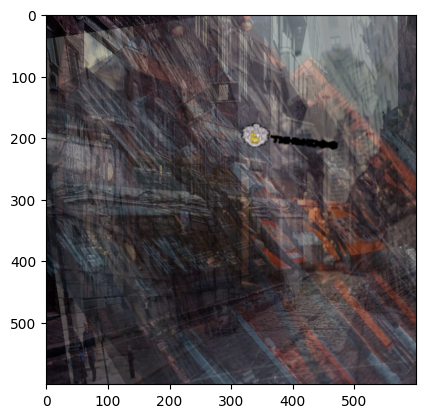

In [11]:
plt.imshow(cv2.imread(f'/content/dataset/train/sample_{14}.png')[:,:,::-1])

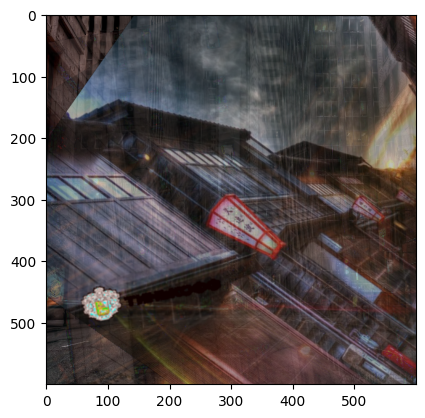

In [12]:
plt.imshow(cv2.imread(f'/content/dataset/train/sample_{27}.png')[:,:,::-1])

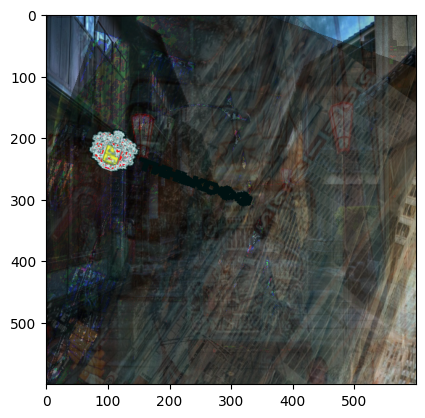

In [13]:
plt.imshow(cv2.imread(f'/content/dataset/train/sample_{50}.png')[:,:,::-1])

In [14]:
generator = ImageGenerator(holder.logos[0], 0, 1)
generator.main("test")
generator = ImageGenerator(holder.logos[1], 1, 1)
generator.main("test")

# Обучение YOLO


In [15]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.9/618.9 kB 8.5 MB/s eta 0:00:00


In [16]:
from ultralytics import YOLO

# Load the model.
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:01<00:00, 49.8MB/s]


In [17]:
results = model.train(
   data='/content/drive/MyDrive/logo_dataset/data.yaml',
   epochs=25,
   batch=16,
   name='gryass'
)

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/logo_dataset/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=gryass, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscrip

In [19]:
terminator2004 = YOLO('/content/runs/detect/gryass/weights/best.pt')

terminator2004.predict('/content/dataset/test/sample_903.png', save=True)


image 1/1 /content/dataset/test/sample_903.png: 640x640 1 tinkoff, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'tinkoff', 1: 'naumen', 2: 'rostelecom', 3: 'ussc', 4: 'sber', 5: 'gosuslugi'}
 orig_img: array([[[138, 172, 192],
         [ 28,  52,  64],
         [ 60,  54,  59],
         ...,
         [102, 107, 108],
         [137, 139, 140],
         [145, 148, 148]],
 
        [[115, 141, 154],
         [ 37,  57,  64],
         [ 48,  45,  50],
         ...,
         [122, 125, 126],
         [146, 150, 150],
         [121, 123, 125]],
 
        [[138, 154, 160],
         [100, 116, 119],
         [ 53,  56,  60],
         ...,
         [145, 148, 149],
         [140, 143, 144],
         [115, 118, 121]],
 
        ...,
 
        [[ 55,  56,  55],
         [ 54,  55,  54],
         [ 58,  59,  58],
         ...,
         [124, 125, 120],
         [ 76,  76,  66],
         [ 74,  75,  67]],
 
        [[ 56,  57,  56],
         [ 58,  59,  58],


In [28]:
terminator2004.predict('/content/dataset/test/test8.png', save=True)


image 1/1 /content/dataset/test/test8.png: 608x640 2 rostelecoms, 2 usscs, 387.3ms
Speed: 8.9ms preprocess, 387.3ms inference, 9.5ms postprocess per image at shape (1, 3, 608, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'tinkoff', 1: 'naumen', 2: 'rostelecom', 3: 'ussc', 4: 'sber', 5: 'gosuslugi'}
 orig_img: array([[[ 36,  33,  32],
         [ 36,  33,  32],
         [ 36,  33,  32],
         ...,
         [ 62, 106, 160],
         [  4,  45, 102],
         [ 32,  56,  95]],
 
        [[ 36,  33,  32],
         [ 36,  33,  32],
         [ 36,  33,  32],
         ...,
         [ 73, 130, 196],
         [102, 155, 224],
         [121, 152, 203]],
 
        [[ 36,  33,  32],
         [ 36,  33,  32],
         [ 36,  33,  32],
         ...,
         [ 76, 133, 202],
         [106, 159, 232],
         [111, 152, 213]],
 
        ...,
 
        [[ 36,  33,  32],
         [ 36,  33,  32],
         [ 36,  33,  32],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 36,  33,  32],
         [ 36,  33,  32],
